In this notebook we compare the "simple" Penman-Monteith calculations made in `create_turbulence_dateset.ipynb`, which rely on an empirical function from the PyET library for calculating aerodynamic resistance, with "stability-adjusted" Penman-Monteith calculations. We do the "stability-adjusted" calculations by using the conductance values from in our TurbPY/MOST model runs.

In [9]:
import os
import numpy as np
import pandas as pd
from sublimpy import tidy
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Open Data 

In [10]:
# Measurements
start_date = '20221130'
end_date = '20230517'
tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

# Model Results
model_df = pd.read_parquet("model_results.parquet")

Add some info to the model_df to make sorting results easier

In [11]:
model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['z0'] = model_df['config'].apply(
    lambda v: float(v.split(' ')[-1])
)

model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)

model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)

model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')

model_df.head()

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,scheme,z0,e_sat_curve,surface_measurement,most_config
0,2022-11-29 17:00:00,Standard Tsurf_c e_sat_metpy 0.0001,0.005086,0.003401,NaN,0.005246,0.005246,yang,0.0001,metpy,Tsurf_c,Standard
1,2022-11-29 17:30:00,Standard Tsurf_c e_sat_metpy 0.0001,0.008932,0.001381,NaN,0.007048,0.007048,yang,0.0001,metpy,Tsurf_c,Standard
2,2022-11-29 18:00:00,Standard Tsurf_c e_sat_metpy 0.0001,0.006719,-0.002035,NaN,0.005670,0.005670,yang,0.0001,metpy,Tsurf_c,Standard
3,2022-11-29 18:30:00,Standard Tsurf_c e_sat_metpy 0.0001,0.001914,-0.001950,NaN,0.002490,0.002490,yang,0.0001,metpy,Tsurf_c,Standard
4,2022-11-29 19:00:00,Standard Tsurf_c e_sat_metpy 0.0001,0.000760,-0.001411,NaN,0.001563,0.001563,yang,0.0001,metpy,Tsurf_c,Standard


# Calculate stability-adjusted Penman-Monteith estimates of sublimation

Gather the measurements we need

In [12]:
pyet_src = tidy_df_30Min[tidy_df_30Min.variable.isin([
    'Rnet_9m_d',
    'airdensity_3m_c',
    'Tsurfvaporpressure_c',
    'vaporpressure_3m_c',
    'T_3m_c',
    'spd_3m_c',
    'P_10m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index()
pyet_src.head(2)

variable,time,P_10m_c,Rnet_9m_d,T_3m_c,Tsurfvaporpressure_c,airdensity_3m_c,spd_3m_c,vaporpressure_3m_c
0,2022-11-29 17:00:00,713.159607,-57.467264,-12.797492,235.782582,0.95436,3.323426,149.831121
1,2022-11-29 17:30:00,713.428101,-79.222653,-13.050861,226.665552,0.95583,4.556745,114.146005


Add in conductance values from the model data

In [13]:
conductance_values = model_df[model_df.config.isin([
    'MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0001',
    'MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0005',
    'Standard Tsurf_c e_sat_alduchov 0.0001',
    'Standard Tsurf_c e_sat_alduchov 0.0005',
])][['time', 'config', 'latent heat conductance']].pivot_table(
    index=['time'],
    values='latent heat conductance',
    columns='config'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index()
conductance_values.head(3)

config,time,MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0001,MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0005,Standard Tsurf_c e_sat_alduchov 0.0001,Standard Tsurf_c e_sat_alduchov 0.0005
0,2022-11-29 17:00:00,2834700.0,2834700.0,0.005246,0.007398
1,2022-11-29 17:30:00,2834700.0,2834700.0,0.007048,0.009940
2,2022-11-29 18:00:00,2834700.0,2834700.0,0.005670,0.007997


In [14]:
pyet_src = pd.merge(pyet_src, conductance_values, on='time', how='left')

In [15]:
# From PyET code
# Equation for calculating the latent heat of vaporization from:
# Richard G Allen, Luis S Pereira, Dirk Raes, Martin Smith, and others. Crop evapotranspiration-Guidelines for computing crop 
# water requirements-FAO Irrigation and drainage paper 56. Fao, Rome, 300(9):D05109, 1998.
pyet_src['L_v estimated'] = 2.501 - 0.002361 * pyet_src['T_3m_c']

In [16]:
def calc_delta_alduchov(t_in_c):
# Taking the derivative of the Alduchov curve
# returns in kPa
    numerator = 37836.5*np.exp((22.587*t_in_c)/(273.86+t_in_c))
    denominator = (t_in_c + 273.86)**2
    # 0.1 to convert from millibars to kPa
    return 0.1*numerator/denominator

def calc_psychrometric_constant(C_p, P, L_v):
    # C_p in MJ/kg/˚C
    # P in kPa
    # L_v in MJ/kg
    # From wikipedia
    # https://en.wikipedia.org/wiki/Psychrometric_constant#cite_note-1
    # which cites this:
    #  Allen, R.G.; Pereira, L.S.; Raes, D.; Smith, M. (1998). Crop Evapotranspiration—Guidelines for Computing Crop Water Requirements. 
    # FAO Irrigation and drainage paper 56. Rome, Italy: Food and Agriculture Organization of the United Nations. ISBN 92-5-104219-5. Retrieved 2007-10-08.
    return C_p*P/(0.622 * L_v)

In [17]:
C_p = 1.013 * 10 ** -3  # MJ/kg/K

def penman_monteith(
    energy_available, # MJ/m^2/day
    density_air, # kg/m^3
    vapor_pressure_surface, # kPa
    vapor_pressure_air, # kPa
    temp_air, # ˚C
    pressure, # kPa
    wind_speed, # m/s
    L_v,
    C_q
):
    A = energy_available
    rho_a = density_air
    e_s = vapor_pressure_surface
    e_a = vapor_pressure_air
    
    # delta = pyet.calc_vpc(temp_air)
    delta = calc_delta_alduchov(temp_air)
    y = calc_psychrometric_constant(C_p, pressure, L_v)
    r_a = 1/(wind_speed * C_q)
    r_s = 0

    numerator = delta*A + rho_a*86400*C_p*(e_s - e_a)/r_a
    denominator = delta + y*(1 + r_s / r_a)
    return (1/L_v)*(numerator/denominator)

Do calculations

In [18]:
from metpy.units import units
import pint_pandas
import pint_xarray

In [19]:
pyet_src['pm results'] = penman_monteith(
    (pyet_src['Rnet_9m_d'].to_xarray() * units("W/m^2")).pint.to("MJ/m^2/day").values,
    pyet_src['airdensity_3m_c'].values,
    (pyet_src['Tsurfvaporpressure_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    (pyet_src['vaporpressure_3m_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    pyet_src['T_3m_c'].values,
    (pyet_src['P_10m_c'].to_xarray() * units("millibars")).pint.to("kPa").values,
    pyet_src['spd_3m_c'].values,
    pyet_src['L_v estimated'].values,
    pyet_src['Standard Tsurf_c e_sat_alduchov 0.0001'].values
)
pyet_src['pm results'] = pyet_src['pm results']/(86.4) # convert from mm/day to g/m^2/s

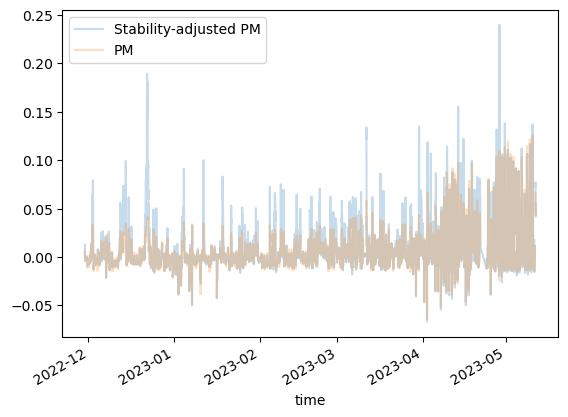

In [20]:
import matplotlib.pyplot as plt
pyet_src.set_index('time')['pm results'].plot(alpha=0.25, label = 'Stability-adjusted PM')
tidy_df_30Min.query("variable == 'w_h2o__3m_c predicted (Penman Monteith)'").set_index('time')['value'].plot(alpha=0.25, label = 'PM')
plt.legend()

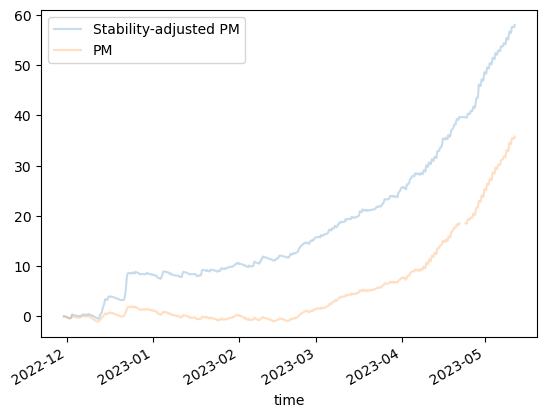

In [21]:
import matplotlib.pyplot as plt
pyet_src.set_index('time')['pm results'].cumsum().plot(alpha=0.25, label = 'Stability-adjusted PM')
tidy_df_30Min.query("variable == 'w_h2o__3m_c predicted (Penman Monteith)'").set_index('time')['value'].cumsum().plot(alpha=0.25, label = 'PM')
plt.legend()

# Add stability-adjusted PM calculations to tidy_df_30Min

In [22]:
# merge with one variable from the tidy dataset so i'm not missing any timesteps
stab_adjusted_pm_predictions = pyet_src[['time', 'pm results']].merge(
    tidy_df_30Min.query("variable == 'w_h2o__3m_c predicted (Penman Monteith)'")[['time', 'value']],
    on = 'time',
    how='right'
)['pm results'].values

tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    stab_adjusted_pm_predictions,
    'w_h2o__3m_c predicted (stability adjusted Penman Monteith)',
    'w_h2o_',
    3,
    'c'
)

In [24]:
tidy_df_30Min.to_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")